In [1]:
%pip install h5py numpy pillow tqdm matplotlib plotly wandb segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-1

In [2]:
import os
import json
import torch
import random
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
import torchvision.transforms as T
import numpy as np
from PIL import Image
import h5py
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from os.path import join as pjoin
import cv2
import wandb
import time
import segmentation_models_pytorch as smp



In [3]:
BATCH_SIZE = 8
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
DATA_FRACTION = 1.0 
RUN_NAME = "uvdoc-segmentation-vaipe-v2.1"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# wandb

from kaggle_secrets import UserSecretsClient
os.environ["WANDB_API_KEY"] = UserSecretsClient().get_secret("WANDB_API_KEY")

%wandb login

In [5]:
class VAIPEPSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(512, 512), transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.image_size = image_size
        
        if transform:
            self.transform = transform
        else:
            self.transform = T.Compose([
                T.Resize(self.image_size),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        
        self.mask_transform = T.Compose([
            T.Resize(self.image_size),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = self.transform(image)
        mask = self.mask_transform(mask)

        return image, mask


In [6]:
# loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice


In [7]:
# train

def train_segmentation(model, train_loader, val_loader, num_epochs, learning_rate, patience=5):
    model.to(DEVICE)
    criterion = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    wandb.init(project="ProjectCV-Segmentation", name=RUN_NAME, config={
        "num_epochs": num_epochs,
        "learning_rate": learning_rate,
        "batch_size": BATCH_SIZE,
        "device": str(DEVICE),
        "model_name": "UNet_ResNet50"
    })

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Training
        model.train()
        train_loss = 0
        for img, mask in train_loader:  # bỏ tqdm
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            optimizer.zero_grad()
        
            pred = model(img)
            loss = criterion(pred, mask)
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for img, mask in val_loader:  # bỏ tqdm
                img, mask = img.to(DEVICE), mask.to(DEVICE)
                pred = model(img)
                loss = criterion(pred, mask)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        

        epoch_time = time.time() - epoch_start_time

        # Log metrics
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "learning_rate": optimizer.param_groups[0]['lr']
        })

        print(
            f"Epoch {epoch+1}/{num_epochs},\n"
            f"Train Loss: {train_loss:.4f},\n"
            f"Val Loss: {val_loss:.4f},\n"
            f"Epoch Time: {epoch_time:.2f} sec\n"
            f"----------------------"
        )

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_segmentation_unet_resnet50_vaipep.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    wandb.finish()


In [8]:
def get_dataloaders(
    data_path="/kaggle/input/vaipe-p-segmentation-synthetic/final_set/train",
    batch_size=8,
    num_workers=4,
    train_split=0.8,
    shuffle_train=True,
    shuffle_val=False,
    data_fraction=1.0,
    transform=None,

):
    image_dir = os.path.join(data_path, "images")
    mask_dir = os.path.join(data_path, "masks")

    dataset = VAIPEPSegmentationDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)

    if data_fraction < 1.0:
        subset_size = int(len(dataset) * data_fraction)
        indices = torch.randperm(len(dataset))[:subset_size]
        dataset = torch.utils.data.Subset(dataset, indices)

    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=shuffle_val,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
    )

    return train_loader, val_loader


In [9]:
# Initialize DataLoaders
train_loader, val_loader = get_dataloaders(
    data_path="/kaggle/input/vaipe-p-segmentation-synthetic/final_set/train",
    batch_size=BATCH_SIZE,
    num_workers=4,
    train_split=0.8,
    data_fraction = DATA_FRACTION
)

print("Data Loaded")

Data Loaded


In [10]:
def visualize_segmentation(img, mask, threshold=0.5):
    img = img.permute(1, 2, 0).cpu().numpy()
    mask = mask.squeeze().cpu().numpy()
    
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(131)
    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")

    
    ax2 = fig.add_subplot(132)
    ax2.imshow(mask)
    ax2.set_title("Mask")
    ax2.axis("off")

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])


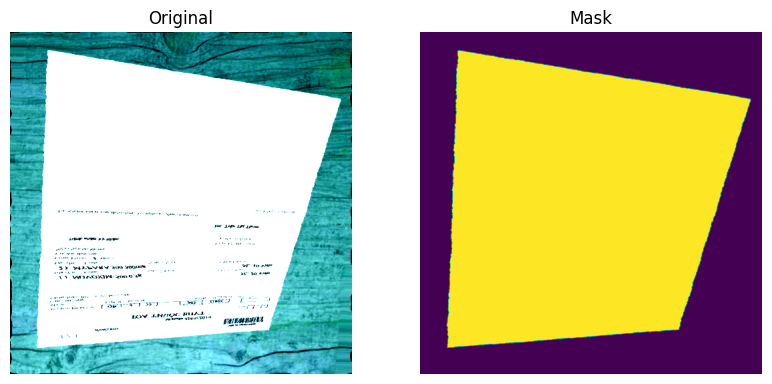

In [11]:
img_rgb, mask = next(iter(train_loader))
print(img_rgb.shape)
print(mask.shape)

i = 2
visualize_segmentation(img_rgb[i], mask[i])

In [12]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(DEVICE)

print("Model Initialized")


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model Initialized


In [13]:
# Train model
torch.cuda.empty_cache()
train_segmentation(model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: khaihoang004 (khaihoang004-hanoi-university-of-science-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250526_081050-7mq7ajuh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run uvdoc-segmentation-vaipe-v2.1
wandb: ⭐️ View project at https://wandb.ai/khaihoang004-hanoi-university-of-science-and-technology/ProjectCV-Segmentation
wandb: 🚀 View run at https://wandb.ai/khaihoang004-hanoi-university-of-science-and-technology/ProjectCV-Segmentation/runs/7mq7ajuh


Epoch 1/30,
Train Loss: 0.0376,
Val Loss: 0.1994,
Epoch Time: 292.20 sec
----------------------
Epoch 2/30,
Train Loss: 0.0184,
Val Loss: 0.0201,
Epoch Time: 285.51 sec
----------------------
Epoch 3/30,
Train Loss: 0.0150,
Val Loss: 0.0250,
Epoch Time: 285.70 sec
----------------------
Epoch 4/30,
Train Loss: 0.0144,
Val Loss: 0.0243,
Epoch Time: 285.89 sec
----------------------
Epoch 5/30,
Train Loss: 0.0133,
Val Loss: 0.0140,
Epoch Time: 285.83 sec
----------------------
Epoch 6/30,
Train Loss: 0.0107,
Val Loss: 0.0236,
Epoch Time: 285.63 sec
----------------------
Epoch 7/30,
Train Loss: 0.0098,
Val Loss: 0.0150,
Epoch Time: 285.65 sec
----------------------
Epoch 8/30,
Train Loss: 0.0102,
Val Loss: 0.0115,
Epoch Time: 285.80 sec
----------------------
Epoch 9/30,
Train Loss: 0.0091,
Val Loss: 0.0097,
Epoch Time: 285.55 sec
----------------------
Epoch 10/30,
Train Loss: 0.0092,
Val Loss: 0.0159,
Epoch Time: 285.45 sec
----------------------
Epoch 11/30,
Train Loss: 0.0090,
Val Lo

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         epoch ▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
wandb: learning_rate ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:    train_loss █▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:      val_loss █▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:         epoch 19
wandb: learning_rate 0.001
wandb:    train_loss 0.00671
wandb:      val_loss 0.01205
wandb: 
wandb: 🚀 View run uvdoc-segmentation-vaipe-v2.1 at: https://wandb.ai/khaihoang004-hanoi-university-of-science-and-technology/ProjectCV-Segmentation/runs/7mq7ajuh
wandb: ⭐️ View project at: https://wandb.ai/khaihoang004-hanoi-university-of-science-and-technology/ProjectCV-Segmentation
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20250526_081050-7mq7ajuh/logs
